## Context

In this project, I splitted the data scraped previously from Uniplaces and predicted the price of part of it.

I was successful in:
1. Doing a exploratory analysis, including transforming variables using log1p, Box-cox and square root.
2. Training and applying the models Ridge, Lasso, Random Forest, Gradient Boosting, Stacking, lightgbm, xgboost
3. Choosing the best model based on RMSLE score
4. Using pipelines to preprocess data and apply models.

**Import libraries**

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from scipy.stats import boxcox
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import normaltest

# preprocessing and pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from scipy.special import inv_boxcox

#models
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Metric error

As metric, Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed price will be used. Using logs makes it that the effects of prediction errors of high and low prices is the same. This is usually called RMSLE.

Given that cross validation will be used, the metric also needs to be adapted.

In [2]:
def do_rmsle (y_real, y_pred): 
    return np.sqrt(mean_squared_log_error(y_real, y_pred))

## Exploratory analysis

In [3]:
df = pd.read_csv("scraped_data/scraping_cleaned_abridged.csv", index_col=0)
df.head(1)

,title,n_thumbnails,rating,type,n_people,n_bedrooms,n_bathrooms,price,url,allows_Occasional overnight guests,allows_Smoking,Wardrobe,Desk,Chairs,Towels,Bed linen,Window,Sofa,Sofa bed,Balcony,Contract,Bills,Extra per tenant,Cleaning Frequency,min_stay_nights,neighboorhood,Wi-Fi,Cable Tv,Central heating,Air conditioning,Outdoor area,Towels & bed linen,Elevator,Accessibility,Toilet,Sink,Shower,Bathtub,Fridge,Freezer,Stove,Oven,Microwave,Washing machine,Dishes & cutlery,Pots & pans,Coffee table,Table,Tv,Chest of drawers,Door lock,Dryer,Dishwasher,one_time_fee,Enclosed balcony,Floor_plan_m2,Bedroom_area_m2,has_private_bathroom,n_living_rooms,n_single_beds,n_double_beds,landlord_lives_here,has_tenant_restrictions,deposit_minus_price,available_immediately
0,Huge double bedroom in an elegant 5-bedroom fl...,31.0,0,Double bedroom,2,5,3,750.0,https://www.uniplaces.com/accommodation/lisbon...,1,0,1,1,1,1,1,2,1,0,1,Fortnightly,Included,200.0,Not specified,27.0,Marquês de Pombal,1,1,1,1,1,1,1,0,3,3,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0.0,0,NaN,NaN,0,1,0,1,0,0,0.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 0 to 958
Data columns (total 65 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               959 non-null    object 
 1   n_thumbnails                        959 non-null    float64
 2   rating                              959 non-null    int64  
 3   type                                959 non-null    object 
 4   n_people                            959 non-null    int64  
 5   n_bedrooms                          959 non-null    int64  
 6   n_bathrooms                         959 non-null    int64  
 7   price                               959 non-null    float64
 8   url                                 959 non-null    object 
 9   allows_Occasional overnight guests  959 non-null    int64  
 10  allows_Smoking                      959 non-null    int64  
 11  Wardrobe                            959 non-n

In [5]:
target = df['price'].copy()
target2 = df['price'].copy()
df = df.drop('price', axis=1)

I have cleaned the dataset before, meaning a lot of categorical variables (all the binaries) are already of type int while numerical are float. Still, the numerical variables will need to have some imputation.

For the remaining object variables I can do one-hot encoding or decide to drop them.

### Target variable

In [6]:
def plot_distplot (data, xlabel, ylabel, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(data, kde=True)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.title(title, fontsize=14)
    plt.show()

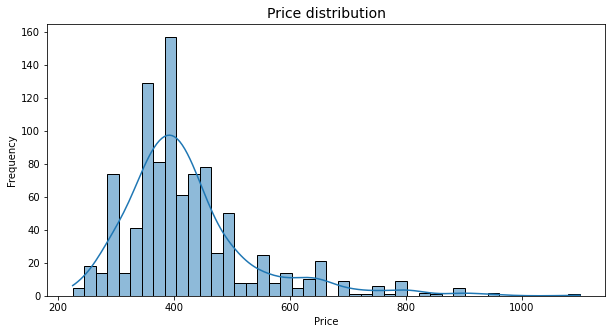

In [7]:
plot_distplot (target, "Price", "Frequency", "Price distribution")

In [8]:
print("Skewness: %f" % skew(target))
print("Kurtosis: %f" % kurtosis(target))

Skewness: 1.729824
Kurtosis: 4.381541


Using these functions from scipy, skewness and kurtosis should be zero. They are not.

We will see how log1p, boxcox and root squared transformations behave and choose the best. It is expected that boxcox will be the best, then log1p and then root squared.

#### Transformations

In [9]:
def print_transformation (value, name, to_print=True):
    skw = skew(value, nan_policy = 'omit')
    kurt = kurtosis(value, nan_policy = 'omit')
    total = skw**2 + kurt**2
    if to_print == True:
        print("{}:\nskewness: {} kurtosis: {} k^2 + s^2: {}".format(name, skw, kurt, total))
    else:
        return total
    
def do_transformations (to_change, to_print=True):
    log1p = np.log1p(to_change)
    total_log1p = print_transformation (log1p, "log1p", to_print)
    root = to_change**(1/2)
    total_root = print_transformation (root, "root_square", to_print)
    
    if (to_change <= 0).any():
        return log1p, root, None
    
    boxcox_d = boxcox(to_change)
    boxcox_array = boxcox_d[0]
    boxcox_lmbda = boxcox_d[1]
    total_boxcox = print_transformation (boxcox_array, "boxcox", to_print)
    
    return log1p, root, boxcox_array, boxcox_lmbda

In [10]:
target_log1p, target_root, target_boxcox, target_lmbda = do_transformations (target)

log1p:
skewness: 0.7245031355055144 kurtosis: 1.115874831365561 k^2 + s^2: 1.7700814326324412
root_square:
skewness: 1.2067473001431865 kurtosis: 2.3269394152874927 k^2 + s^2: 6.8708860888213685
boxcox:
skewness: -0.026208712860762803 kurtosis: 0.47728592750236043 k^2 + s^2: 0.22848875322160636


Box-Cox was the best followed by log1p. 

In [11]:
def do_best_transformation (target):
    if (target <= 0).any():
        return np.log1p(target)
    return boxcox(target)[0]

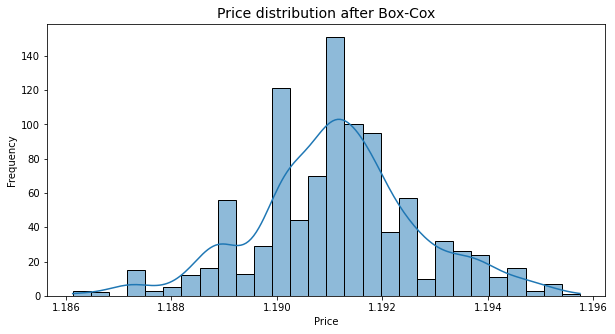

In [12]:
target = pd.Series(target_boxcox)
plot_distplot (target, "Price", "Frequency", "Price distribution after Box-Cox")

### Categorical variables

While the computer is good in finding connections, the human touch is better. So I will group some with variables. 

I will also rename some columns and drop others of items that I am almost certain most exist in any household (e.g. chairs).

In [13]:
df_categorical = df.select_dtypes(include = ["object", "int64"])

#### Group and drop variables, and add prefix

In [14]:
tmp_cols = ['Towels', 'Bed linen', 'Towels & bed linen']
df["has_towels_and_linen"] = np.where((df[tmp_cols[0:2]].sum(axis=1) == 2) | 
                                      (df[tmp_cols[2]] == 1), 1, 0)
df = df.drop(tmp_cols, axis=1)

tmp_cols = ['Wardrobe', 'Chest of drawers']
df["has_furniture_for_clothing"] = np.where(df[tmp_cols].sum(axis=1) > 0, 1, 0)
df = df.drop(tmp_cols, axis=1)

tmp_cols = ['Central heating', 'Air conditioning']
df["has_heating_cooling"] = np.where(df[tmp_cols].sum(axis=1) > 0, 1, 0)
df = df.drop(tmp_cols, axis=1)   

tmp_cols = ['Dishes & cutlery', 'Pots & pans']
df["has_all_kitchenware"] = np.where(df[tmp_cols].sum(axis=1) == len(tmp_cols), 1, 0)
df = df.drop(tmp_cols, axis=1)   

tmp_cols = ['Sofa', 'Sofa bed']
df["has_sofa"] = np.where(df[tmp_cols].sum(axis=1) > 0, 1, 0)
df = df.drop(tmp_cols, axis=1) 

tmp_cols = ['Balcony', 'Enclosed balcony']
df["has_balcony"] = np.where(df[tmp_cols].sum(axis=1) > 0, 1, 0)
df = df.drop(tmp_cols, axis=1) 

tmp_cols = ['Tv', 'Cable Tv']
df["has_tv"] = np.where(df[tmp_cols].sum(axis=1) > 0, 1, 0)
df = df.drop(tmp_cols, axis=1) 

tmp_cols = ['Fridge', 'Stove']
df["has_basic_appliances"] = np.where(df[tmp_cols].sum(axis=1) == len(tmp_cols), 1, 0)
df = df.drop(tmp_cols, axis=1) 

tmp_cols = ['Freezer', 'Oven', 'Microwave', 'Washing machine', 'Dryer', 'Dishwasher']
df["has_extra_appliances"] = np.where(df[tmp_cols].sum(axis=1) > 0, 1, 0)
df = df.drop(tmp_cols, axis=1) 

tmp_cols = ['Elevator', 'Accessibility']
df["has_accessibility_features"] = np.where(df[tmp_cols].sum(axis=1) > 0, 1, 0)
df = df.drop(tmp_cols, axis=1) 

In [15]:
to_prefix = ['Desk', 'Wi-Fi', 'Outdoor area', 'Bathtub', 'Door lock']
tmp_cols = [(x, "has_" + x) for x in to_prefix]

df = df.rename(columns = dict(tmp_cols))

tmp_cols = [col for col in df_categorical.columns if '_' not in col]
tmp_cols2 = [col for col in tmp_cols if col in ['title', 'url', 'Chairs', 'Window','Toilet',
                                                    'Sink', 'Shower','Coffee table', 'Table']]

df = df.drop(tmp_cols2, axis=1)
df_categorical = df.select_dtypes(include = ["object", "int64"])

In [16]:
df_categorical.columns

Index(['rating', 'type', 'n_people', 'n_bedrooms', 'n_bathrooms',
       'allows_Occasional overnight guests', 'allows_Smoking', 'has_Desk',
       'Contract', 'Bills', 'Cleaning Frequency', 'neighboorhood', 'has_Wi-Fi',
       'has_Outdoor area', 'has_Bathtub', 'has_Door lock',
       'has_private_bathroom', 'n_living_rooms', 'n_single_beds',
       'n_double_beds', 'landlord_lives_here', 'has_tenant_restrictions',
       'available_immediately', 'has_towels_and_linen',
       'has_furniture_for_clothing', 'has_heating_cooling',
       'has_all_kitchenware', 'has_sofa', 'has_balcony', 'has_tv',
       'has_basic_appliances', 'has_extra_appliances',
       'has_accessibility_features'],
      dtype='object')

#### Relation with target

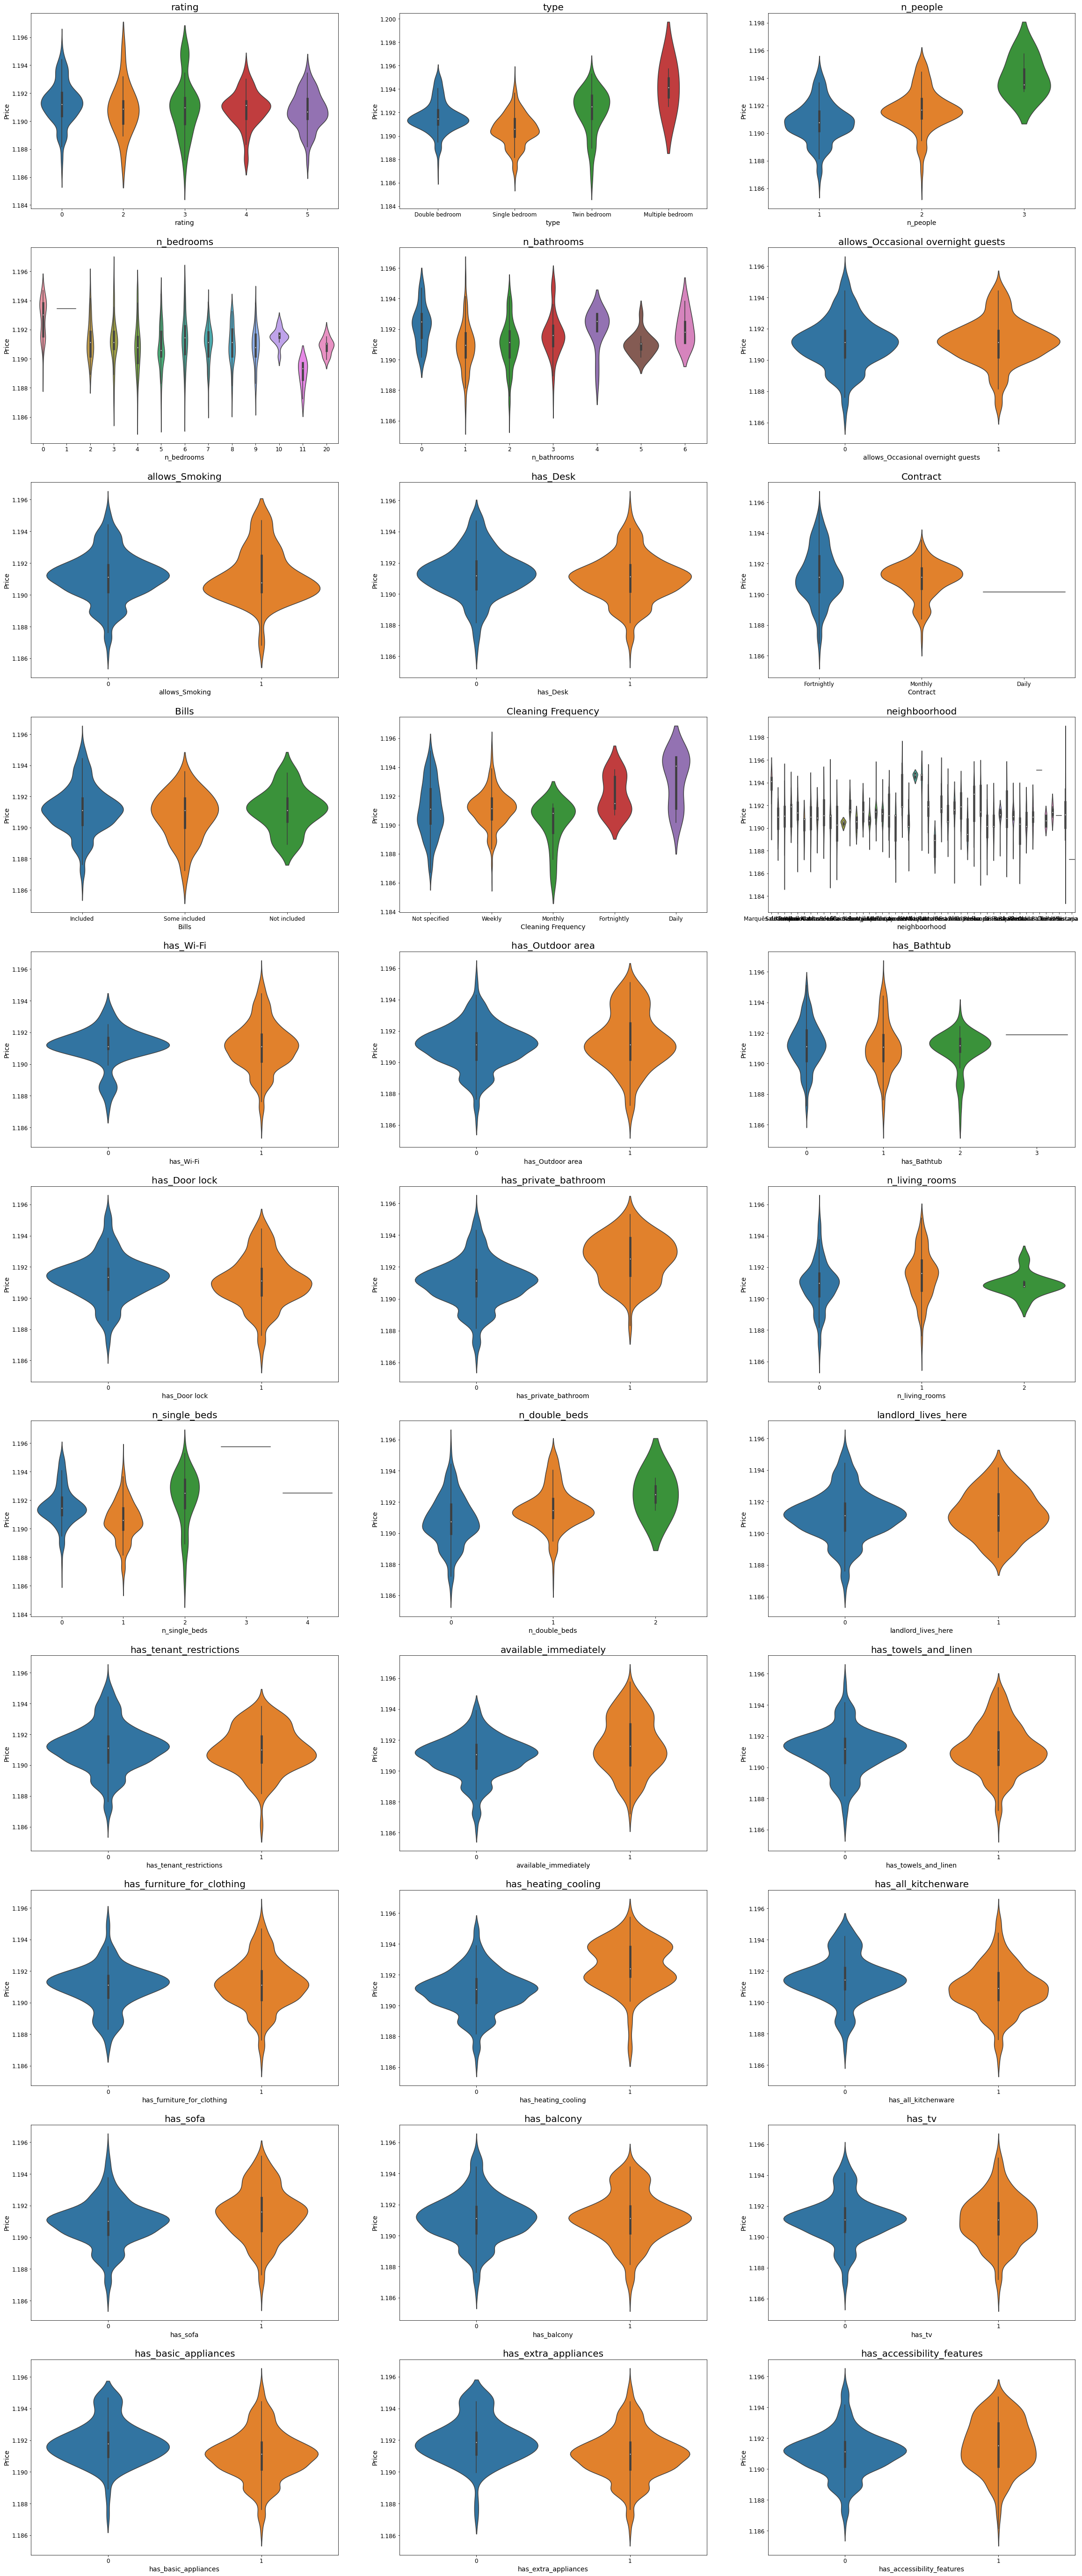

In [17]:
count = 0
fig, axes = plt.subplots(11, 3, figsize=(40, 100))

for i in range (11):
    for j in range (3):
        b = sns.violinplot(ax=axes[i, j], data=df_categorical, x=df_categorical.columns[count], y=target)
        b.axes.set_title(df_categorical.columns[count],fontsize=20)
        b.axes.set_xlabel(df_categorical.columns[count],fontsize=14)
        b.axes.set_ylabel('Price',fontsize=14)
        b.axes.tick_params(axis='both', labelsize=12)

        count = count + 1

Type, 'Cleaning Frequency', 'neighboorhood', 'has_private_bathroom', 'landlord_lives_here', 'available_immediately', 'has_heating_cooling', 'has_basic_appliances', 'has_extra_appliances', 'has_accessibility_features', 'n_bedrooms', 'n_single_beds', 'n_double_beds' seem to have the biggest impact on price.

### Numerical variables

ML models work better with normal data. It is best to start from there.

We also need to check their normality like we did with target.

In [18]:
df_float = df.select_dtypes(include = "float")

In [19]:
df_float.columns

Index(['n_thumbnails', 'Extra per tenant', 'min_stay_nights', 'one_time_fee',
       'Floor_plan_m2', 'Bedroom_area_m2', 'deposit_minus_price'],
      dtype='object')

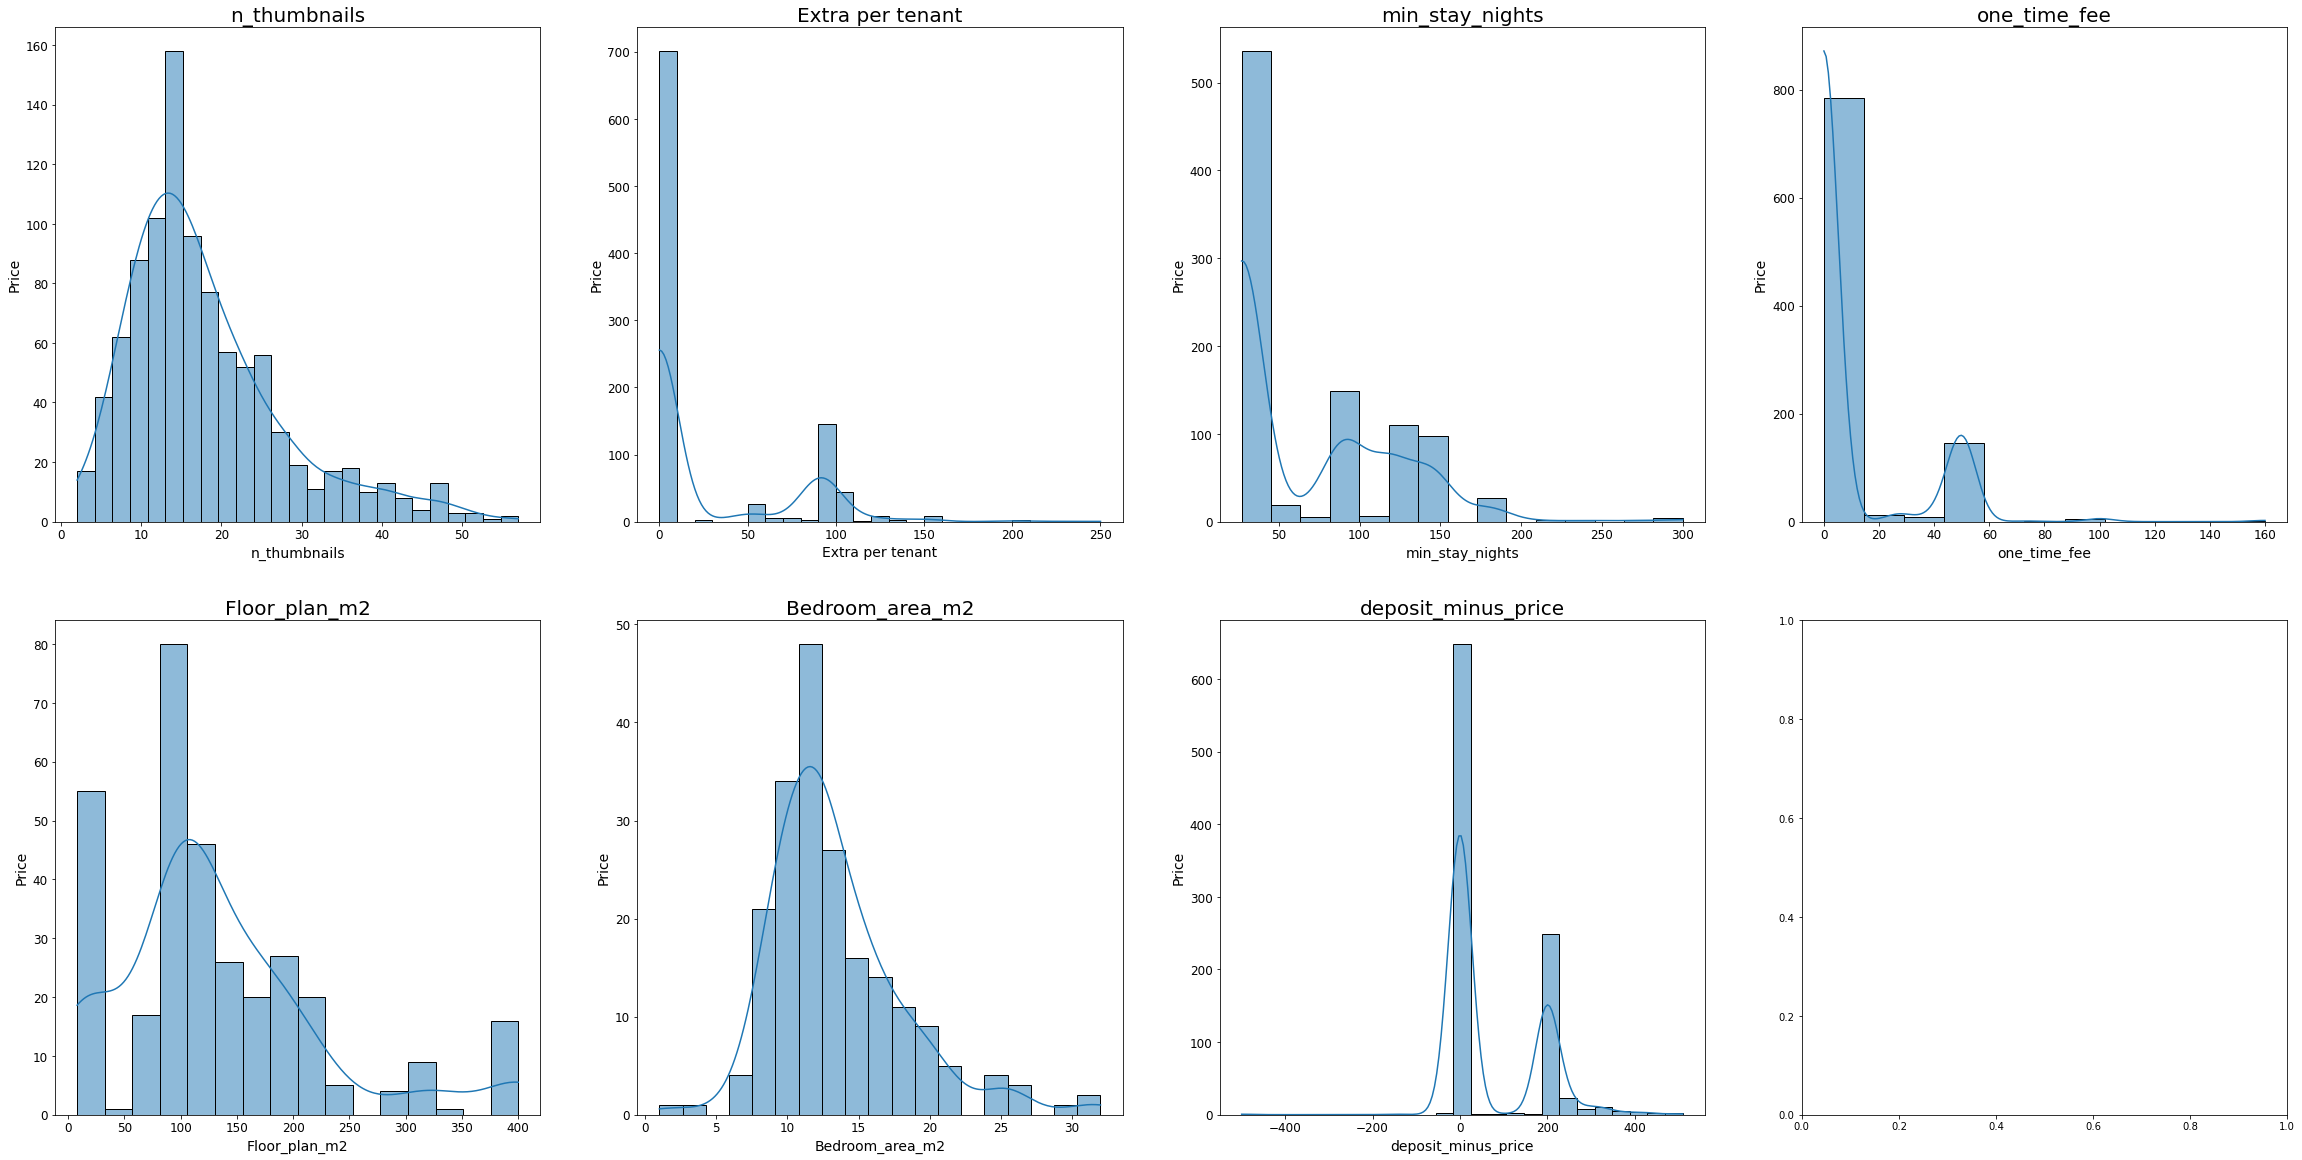

In [20]:
count = 0
fig, axes = plt.subplots(2, 4, figsize=(40, 20))

for i in range (2):
    for j in range (4):
        if count < 7:
            b = sns.histplot(ax=axes[i, j], data=df, x=df_float.columns[count], kde=True)
            b.axes.set_title(df_float.columns[count],fontsize=20)
            b.axes.set_xlabel(df_float.columns[count],fontsize=14)
            b.axes.set_ylabel('Price',fontsize=14)
            b.axes.tick_params(axis='both', labelsize=12)
            count = count + 1

Some of these variables will never be normal, no matter the transformation they undergo.
The ones that may be normalized are 'n_thumbnails', 'Floor_plan_m2', 'Bedroom_area_m2'

In [21]:
cols = ['n_thumbnails','Floor_plan_m2', 'Bedroom_area_m2']
for col in cols:
    print("\n"+col)
    do_transformations (df[col], to_print=True)


n_thumbnails
log1p:
skewness: -0.38935319154056897 kurtosis: 0.8037722950593391 k^2 + s^2: 0.7976458100677843
root_square:
skewness: 0.44697152066082724 kurtosis: 0.3017456634682043 k^2 + s^2: 0.2908339857037191
boxcox:
skewness: 0.023678063524601597 kurtosis: 0.36784203087849 k^2 + s^2: 0.13586841037308706

Floor_plan_m2
log1p:
skewness: -1.0353697286839423 kurtosis: 0.3716392948472045 k^2 + s^2: 1.2101062405495875
root_square:
skewness: 0.03978315355594423 kurtosis: 0.0016580667193819565 k^2 + s^2: 0.00158544849210176
boxcox:
skewness: 4.035350613466413 kurtosis: 14.609208516272492 k^2 + s^2: 229.71302804553247

Bedroom_area_m2
log1p:
skewness: -0.8160557799421478 kurtosis: 6.146782873340291 k^2 + s^2: 38.4488867279665
root_square:
skewness: 0.378751213349046 kurtosis: 2.250420438067075 k^2 + s^2: 5.207844629683382
boxcox:
skewness: 7.868024990651502 kurtosis: 64.56687522536369 k^2 + s^2: 4230.7871936212005


For n_thumbnails, Box-Cox is best.
For Floor_plan_m2 and Bedroom_area_m2 root_square is best.

In [22]:
df["n_thumbnails"] = boxcox(df["n_thumbnails"])[0]

df['Floor_plan_m2'] = df['Floor_plan_m2']**(1/2)
df['Bedroom_area_m2'] = df['Bedroom_area_m2']**(1/2)

In [23]:
to_drop = [col for col in df_float.columns if col not in cols]

df = df.drop(to_drop, axis=1)
df_float = df_float.drop(to_drop, axis=1)

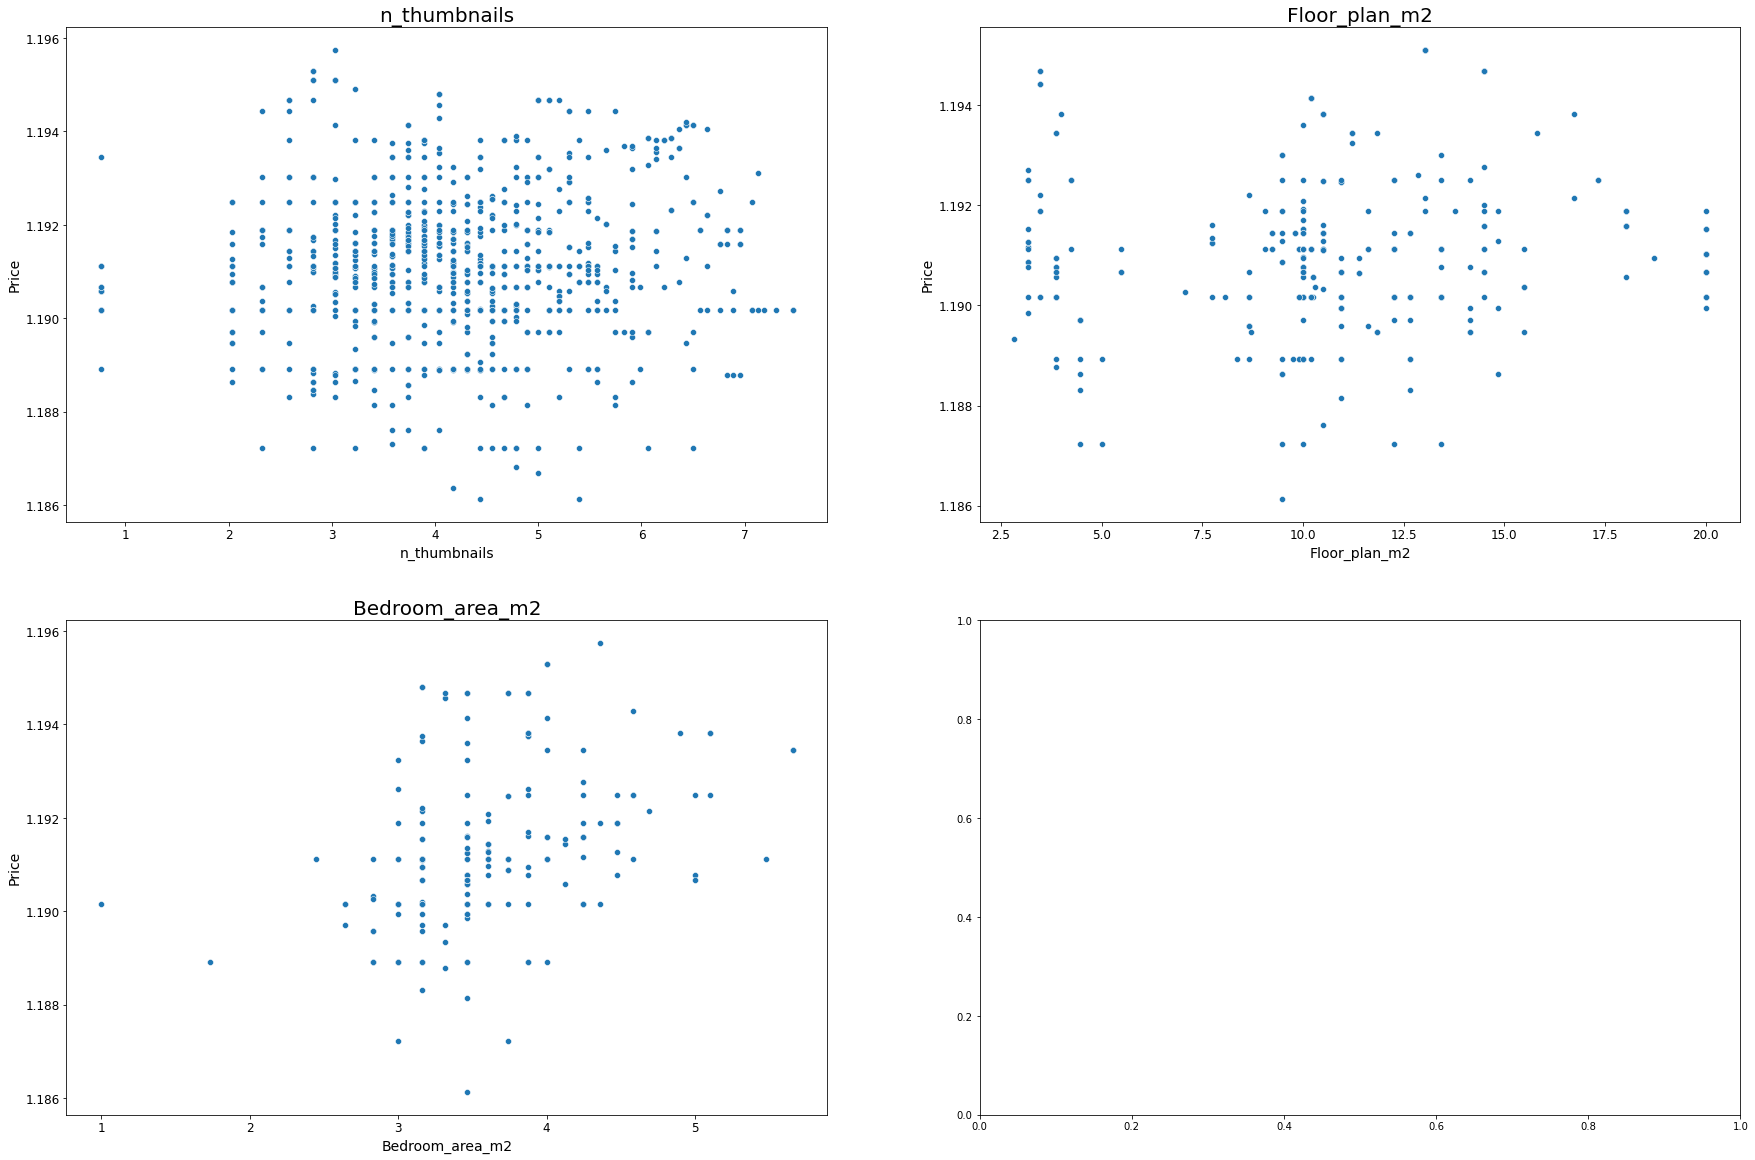

In [24]:
count = 0
fig, axes = plt.subplots(2, 2, figsize=(30, 20))

for i in range (2):
    for j in range (2):
        if count < 3:
            b = sns.scatterplot(ax=axes[i, j], data=df, x=df_float.columns[count], y=target)
            b.axes.set_title(df_float.columns[count],fontsize=20)
            b.axes.set_xlabel(df_float.columns[count],fontsize=14)
            b.axes.set_ylabel('Price',fontsize=14)
            b.axes.tick_params(axis='both', labelsize=12)

            count = count + 1

'Bedroom_area_m2' is the one more correlated with target.

We can check again the skewness and kurtosis, and if in particular skewness is too high (>0.75) then it is best to drop it.

In [25]:
for col in df_float.columns:
    skw = skew(df[col], nan_policy='omit')
    kurt = kurtosis(df[col], nan_policy='omit')
    print("{}\nskew:{} kurt:{} skew^2+kurt^2:{}".format(col, skw, kurt, skw**2+kurt**2))
    if skw > 0.75:
        df = df.drop(col, axis=1)
        df_float = df_float.drop(col, axis=1)
        print('Dropped')

n_thumbnails
skew:0.023678063524601597 kurt:0.36784203087849 skew^2+kurt^2:0.13586841037308706
Floor_plan_m2
skew:0.03978315355594423 kurt:0.0016580667193819565 skew^2+kurt^2:0.00158544849210176
Bedroom_area_m2
skew:0.378751213349046 kurt:2.250420438067075 skew^2+kurt^2:5.207844629683382


## Check nulls

In [26]:
df.isnull().sum()[df.isnull().sum() > 0]

Floor_plan_m2      632
Bedroom_area_m2    758
dtype: int64

Only numerical columns have nulls.

## Preprocessing
There are multiple ways of one-hot encoding object variables. I am more used to use to use the pandas.get_dummies() for it, but here I will use sklearn functions and in particular pipelines.

I found this link useful:
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [29]:
cols_cat = ['type', 'Contract', 'Bills', 'Cleaning Frequency', 'neighboorhood']
# there is just one step, no need of a pipeline
transformer_cat = OneHotEncoder(handle_unknown="ignore")

cols_num = df_float.columns
transformer_num = Pipeline(steps=[("imputer", KNNImputer(n_neighbors=2)), 
                                    ("scaler", RobustScaler())])

preprocessor = ColumnTransformer(transformers=[("cat", transformer_cat, cols_cat),
                                               ("num", transformer_num, cols_num)],
                                remainder='passthrough')

## Prepare training

### Cross validation

I will use cross validation because it makes it easier to find the optimal parameters (like alphas). But the score is not calculated using cross validation.

In [30]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

### Prepare models

#### Linear models

sklearn has several linear models.
However for this I will only use RidgeCV and LassoCV. 

The alpha candidates were chosen by trial and error, checking the attribute alpha after fit.

I found this link useful: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

In [31]:
alphas_ridge = list(np.arange(2,3,0.1))

rd = RidgeCV(alphas=alphas_ridge)

ridge = Pipeline(steps=[("preprocessor", preprocessor),
                        ("ridge", rd)])

ls = LassoCV(max_iter=1e6, random_state=42, cv=kfolds)

lasso = Pipeline(steps=[("preprocessor", preprocessor),
                        ("lasso", ls)])

#### Ensemble methods

In [32]:
rf = RandomForestRegressor(n_estimators=1200, max_depth=15, min_samples_split=5, min_samples_leaf=5,
                          max_features=None, oob_score=True, random_state=42)


random_forest = Pipeline(steps=[("preprocessor", preprocessor), 
                                ("random_forest", rf)])

gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                               max_depth=6, max_features='sqrt', 
                               min_samples_leaf=15, min_samples_split=10,
                               loss='huber', random_state =42)

gradient_boost = Pipeline(steps=[("preprocessor", preprocessor), 
                                 ("gradient", gb)])


xgb =  XGBRegressor(learning_rate=0.01,n_estimators=3000, max_depth=3, min_child_weight=0,
                    gamma=0, subsample=0.7, colsample_bytree=0.7, objective='reg:squarederror', 
                    nthread=-1, scale_pos_weight=1, seed=42, reg_alpha=0.00006)


xgboost = Pipeline(steps=[("preprocessor", preprocessor),
                          ("xgboost", xgb)])

lgb = LGBMRegressor(objective='regression', num_leaves=4, learning_rate=0.01, n_estimators=5000,
                    max_bin=200, bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
                    feature_fraction=0.2, feature_fraction_seed=7, verbose=-1)

lightgbm = Pipeline(steps=[("preprocessor", preprocessor),
                           ("lightgbm", lgb)])


test = [('rd', rd),('ls', ls), ('xgb', xgb)]

st = StackingRegressor(estimators=test, final_estimator=xgb)

#st = StackingRegressor(estimators=(rd, ls, rf, gb, xgb, lgb), final_estimator=xgb)

stack = Pipeline(steps=[("preprocessor", preprocessor), 
                          ("stack", st)])

### Split set and do fit
We will randomly (random_state=42) split as 60% to train, 20% to validation and 20%  to test.

In [33]:
X_train, X_tmp, y_train, y_tmp = train_test_split(df, target, test_size=0.4, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_tmp, y_tmp, 
                                                              test_size=0.5, random_state=42)

# ys are not exactly the same as the ones from the target, because of rounding erros 
y_validation = target2[y_validation.index] 
y_test = target2[y_test.index] 

### Find best alpha candidates for ridge

In [34]:
#fit = ridge.fit(X_train, y_train)
#fit['ridge'].alpha_

## Apply models

In [35]:
models = {'ridge':{'model':ridge}, 'lasso':{'model':lasso}, 'random_forest':{'model':random_forest}, 
          'gradient_boost':{'model':gradient_boost}, 'xgboost':{'model':xgboost}, 
          'lightgbm':{'model':lightgbm}, 'stack':{'model':stack}}

for key in models.keys():
    print(key)
    model = models[key]['model']
    models[key]['fit'] = model.fit(X_train, y_train)
    models[key]['val_prediction'] = models[key]['fit'].predict(X_validation)
    models[key]['y_val_after_boxcox'] = pd.Series(
        inv_boxcox(models[key]['val_prediction'], target_lmbda), index = y_validation.index)
    models[key]['val_rmsle_score'] = do_rmsle (y_validation, models[key]['y_val_after_boxcox']) 

ridge
lasso
random_forest
gradient_boost
xgboost
lightgbm
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
stack


## Scores by model 

In [36]:
for key in models.keys():
    print(models[key]['val_rmsle_score'], key)

0.1649034557871615 ridge
0.1632411296946164 lasso
0.14962394615704366 random_forest
0.14123231759473365 gradient_boost
0.1369479363166664 xgboost
0.1522320617877163 lightgbm
0.15590887032310935 stack


The models with the lowest score are xgboost and gradient_boost.
I will blend models and see if the score improves.

In [37]:
def blend_models_predict(models_dict, pred_key):
    v = 0.0
    return ((v * models_dict['ridge'][pred_key]) + 
            (v * models_dict['lasso'][pred_key]) + 
            (v * models_dict['random_forest'][pred_key]) + 
            (0.5 * models_dict['gradient_boost'][pred_key]) + 
            (0.5 * models_dict['xgboost'][pred_key]) + 
            (v * models_dict['lightgbm'][pred_key]) + 
            (v * models_dict['stack'][pred_key]))

def get_y_score_blended (models_dict, y_real, pred_key, target_lmbda = target_lmbda):
    y_pred = blend_models_predict(models_dict, pred_key)
    y_pred = inv_boxcox(y_pred, target_lmbda)
    if len(y_real) == 0:
        return y_pred
    score = do_rmsle (y_real, y_pred)   
    return y_pred, score

In [38]:
y_blended, score_blended = get_y_score_blended (models, y_validation, 'val_prediction')
print("Blended score: {}".format(score_blended))

Blended score: 0.13319696495781758


## Apply best model to test

Blended was the best model. 

In [39]:
for key in models.keys():
    print(key)
    model = models[key]['model']
    models[key]['test_prediction'] = models[key]['fit'].predict(X_test)
    models[key]['y_test_after_boxcox'] = pd.Series(
        inv_boxcox(models[key]['test_prediction'], target_lmbda), index = y_test.index)

ridge
lasso
random_forest
gradient_boost
xgboost
lightgbm
stack


In [40]:
y_test_blended = get_y_score_blended (models, "", 'test_prediction')
y_test_blended = pd.Series(y_test_blended, index = y_test.index)

In [41]:
df_to_plot = pd.DataFrame([y_test_blended, y_test], index = ["Predicted", "Real"]).T
df_to_plot = df_to_plot.sort_values(by=['Real', 'Predicted'])
df_to_plot.head(5)

,Predicted,Real
820,303.135534,250.0
155,308.500689,250.0
848,348.676323,250.0
2,294.993014,260.0
739,337.803492,275.0


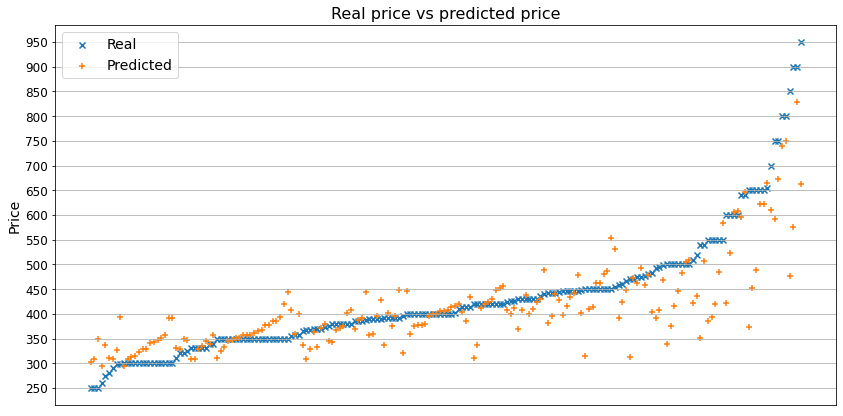

In [42]:
plt.figure(figsize=(14,7))

plt.scatter(np.arange(0,len(df_to_plot), 1), df_to_plot["Real"], label = "Real", marker='x')
plt.scatter(np.arange(0,len(df_to_plot), 1), df_to_plot["Predicted"], label = "Predicted", marker='+')
plt.legend(fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks([])
plt.yticks(np.arange(250,1000, 50), fontsize=12)
plt.title("Real price vs predicted price", fontsize=16)
plt.grid(True)

## Conclusions

Most of the predicted prices are close to the real ones, particular if less than 400.

Still, the prediction can be improved by tuning the parameters of the different models. 
However that will be work for the future.

(also on top)

For now, I successfully:
1. Did a exploratory analysis, including transforming variables using log1p, Box-cox and square root.
2. Trained and applied the models Ridge, Lasso, Random Forest, Gradient Boosting, Stacking, lightgbm, xgboost
3. Chose the best model based on RMSLE score
4. Used pipelines to preprocess data and apply models.